In [126]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
import random


In [116]:
!pip3 install matplotlib


## Part 1: Using the Spectrogram Image to classify the Music


### Data Prepocessing

class_to_idx: {'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}
class_names: ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
Total samples: 999
Unique labels: [0 1 2 3 4 5 6 7 8 9]

Dataset split - Train: 799, Val: 99, Test: 101


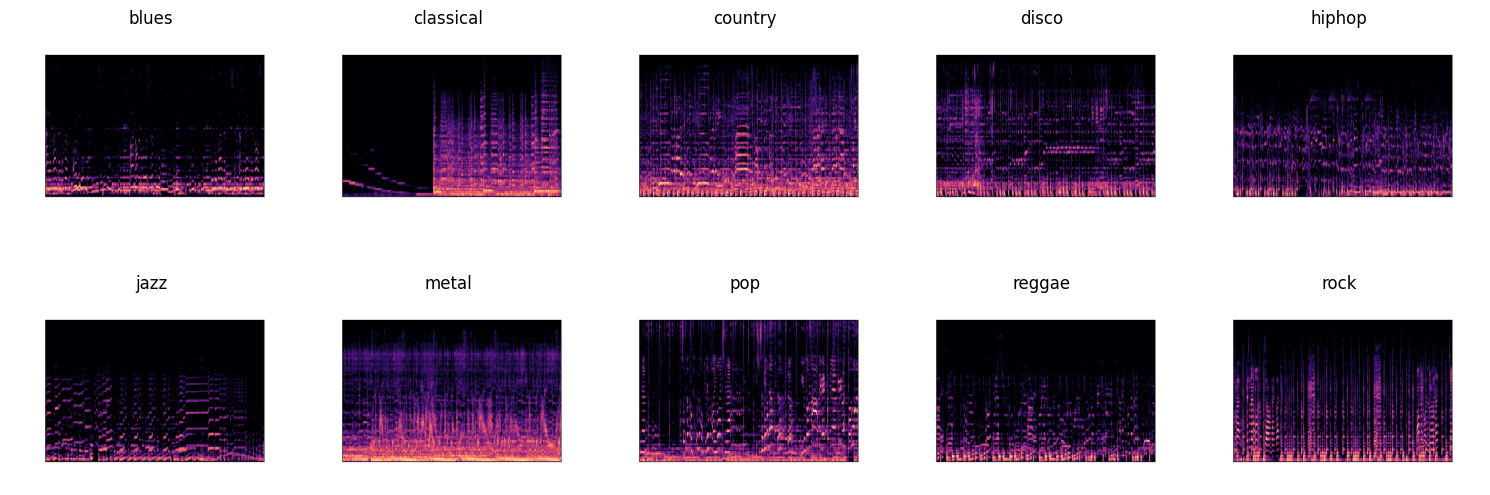

In [127]:

root_dir = "./images_original"
img_size = 128
batch_size = 32

# Get class names
class_names = sorted([
    d for d in os.listdir(root_dir)
    if os.path.isdir(os.path.join(root_dir, d)) and not d.startswith(".")
])
class_to_idx = {name: idx for idx, name in enumerate(class_names)}

print("class_to_idx:", class_to_idx)
print("class_names:", class_names)

# Collect file paths and labels
filepaths = []
labels = []

for genre in class_names:
    genre_folder = os.path.join(root_dir, genre)
    for fname in os.listdir(genre_folder):
        if fname.lower().endswith(".png"):
            filepaths.append(os.path.join(genre_folder, fname))
            labels.append(class_to_idx[genre])

filepaths = np.array(filepaths)
labels = np.array(labels, dtype=np.int32)

print("Total samples:", len(filepaths))
print("Unique labels:", np.unique(labels))

# Preprocessing function
def load_and_preprocess(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, [img_size, img_size])
    img = tf.cast(img, tf.float32) / 255.0
    return img, label

# Create train/val/test splits
dataset_size = len(filepaths)
train_size = int(0.8 * dataset_size)
val_size = int(0.1 * dataset_size)

ds = tf.data.Dataset.from_tensor_slices((filepaths, labels))
ds = ds.shuffle(dataset_size, seed=42, reshuffle_each_iteration=False)

train_ds = ds.take(train_size)
rest_ds = ds.skip(train_size)
val_ds = rest_ds.take(val_size)
test_ds = rest_ds.skip(val_size)

# Apply preprocessing and batching
train_ds = train_ds.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_ds = val_ds.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_ds = test_ds.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

print(f"\nDataset split - Train: {train_size}, Val: {val_size}, Test: {dataset_size - train_size - val_size}")

# Collect one sample from each genre
sample_images = {}
for genre in class_names:
    genre_folder = os.path.join(root_dir, genre)
    genre_files = [f for f in os.listdir(genre_folder) if f.lower().endswith(".png")]
    if genre_files:
        sample_path = os.path.join(genre_folder, random.choice(genre_files))
        sample_images[genre] = Image.open(sample_path)

# Display samples
n_classes = len(class_names)
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for i, genre in enumerate(class_names):
    if genre in sample_images:
        axes[i].imshow(sample_images[genre])
        axes[i].set_title(genre)
        axes[i].axis('off')

plt.tight_layout()
plt.show()


### Model Training

In [128]:
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess
from tensorflow.keras import layers, models, Input


In [129]:
from tensorflow.keras import layers, models

def build_cnn(input_shape=(128, 128, 3), num_classes=10):
    """
    Build a simple CNN model for spectrogram classification
    """
    model = models.Sequential([
        # Conv Block 1
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        
        # Conv Block 2
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        
        # Conv Block 3
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        
        # Conv Block 4
        layers.Conv2D(256, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        
        # Fully connected layers
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ], name='CNN_Spectrogram')
    
    return model

# Build and compile CNN model
cnn_model = build_cnn(input_shape=(128, 128, 3), num_classes=len(class_names))

cnn_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Print model summary
print("="*50)
print("CNN Model Summary")
print("="*50)
cnn_model.summary()

CNN Model Summary


/usr/local/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "CNN_Spectrogram"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_22 (Conv2D)              │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 512)            │     4,719,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,243,338 (20.00 MB)

 Trainable params: 5,242,378 (20.00 MB)

 Non-trainable params: 960 (3.75 KB)

In [130]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models, Input


def build_resnet50(input_shape=(128, 128, 3), num_classes=10):
    """
    Build ResNet50 transfer learning model for spectrogram classification
    """
    inputs = Input(shape=input_shape)
    
    # Load ResNet50 with ImageNet weights
    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_tensor=inputs
    )
    
    # Freeze base model layers
    base_model.trainable = False
    
    # Add classification head
    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = models.Model(inputs, outputs, name='ResNet50_Transfer')
    
    return model

# Build and compile ResNet50 model
resnet_model = build_resnet50(input_shape=(128, 128, 3), num_classes=len(class_names))

resnet_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Print model summary
print("="*50)
print("ResNet50 Model Summary")
print("="*50)
resnet_model.summary()

ResNet50 Model Summary


Model: "ResNet50_Transfer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_18      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 134, 134,  │          0 │ input_layer_18[0… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 64, 64,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 64, 64,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 64, 64,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 66, 66,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 32, 32,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 32,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 32,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 32,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 32,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 32, 32,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 32, 32,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 32, 32,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 32, 32,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_3_c

 Total params: 24,770,698 (94.49 MB)

 Trainable params: 1,182,986 (4.51 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [131]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, Input



def build_vgg16(input_shape=(128, 128, 3), num_classes=10):
    """
    Build VGG16 transfer learning model for spectrogram classification
    """
    inputs = Input(shape=input_shape)
    
    # Load VGG16 with ImageNet weights
    base_model = VGG16(
        weights='imagenet',
        include_top=False,
        input_tensor=inputs
    )
    
    # Freeze base model layers
    base_model.trainable = False
    
    # Add classification head
    x = layers.Flatten()(base_model.output)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = models.Model(inputs, outputs, name='VGG16_Transfer')
    
    return model

# Build and compile VGG16 model
vgg_model = build_vgg16(input_shape=(128, 128, 3), num_classes=len(class_names))

vgg_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Print model summary
print("="*50)
print("VGG16 Model Summary")
print("="*50)
vgg_model.summary()

VGG16 Model Summary


Model: "VGG16_Transfer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_19 (InputLayer)     │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 10)             │         2,57

 Total params: 19,043,402 (72.64 MB)

 Trainable params: 4,328,714 (16.51 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [133]:
from tensorflow import keras


def train_model(model, train_data, val_data, model_name, epochs=50, patience=5):

    # Early stopping
    early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=patience,
        restore_best_weights=True,
        verbose=1
    )
    
    # Reduce learning rate on plateau
    reduce_lr = keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    )
    
    # Save best model
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath=f"{model_name.replace(' ', '_')}_best.keras",
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
    
    print(f"Training {model_name} ...")
    
    # Train the model
    history = model.fit(
        train_data,
        validation_data=val_data,
        epochs=epochs,
        callbacks=[early_stopping, reduce_lr, checkpoint],
        verbose=1
    )
    
    return history, model

In [139]:
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np



def evaluate_model(model, test_data, model_name):
    """
    Evaluate trained model on the test set
    
    Args:
        model: Trained Keras model
        test_data: Test dataset
        model_name: Name of the model
    
    Returns:
        Dictionary with accuracy, loss, precision, recall, F1 score
    """
    
    print("\n" + "="*80)
    print(f"Evaluating {model_name}")
    print("="*80)
    
    # Evaluate loss & accuracy
    loss, accuracy = model.evaluate(test_data, verbose=1)
    
    # Collect predictions
    y_true = []
    y_pred = []
    
    for images, labels in test_data:
        preds = model.predict(images, verbose=0)
        preds = np.argmax(preds, axis=1)
        
        y_true.extend(labels.numpy())
        y_pred.extend(preds)
    
    # Convert to numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Multi-class metrics
    precision = precision_score(y_true, y_pred, average="macro", zero_division=0)
    recall = recall_score(y_true, y_pred, average="macro", zero_division=0)
    f1 = f1_score(y_true, y_pred, average="macro", zero_division=0)
    
    print(f"\nResults for {model_name}:")
    print(f"  Loss:      {loss:.4f}")
    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1 Score:  {f1:.4f}")
    
    return {
        "loss": loss,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1
    }

In [135]:


history_cnn, trained_cnn = train_model(
    cnn_model,
    train_ds,
    val_ds,
    model_name="CNN_Spectrogram",
    epochs=50,
    patience=5
)

cnn_results = evaluate_model(trained_cnn, test_ds, "CNN_Spectrogram")

Training CNN_Spectrogram ...
Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - accuracy: 0.1245 - loss: 6.6302
Epoch 1: val_accuracy improved from -inf to 0.13131, saving model to CNN_Spectrogram_best.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 14s 429ms/step - accuracy: 0.1258 - loss: 6.5601 - val_accuracy: 0.1313 - val_loss: 5.8467 - learning_rate: 0.0010
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step - accuracy: 0.2326 - loss: 2.4216
Epoch 2: val_accuracy did not improve from 0.13131
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 372ms/step - accuracy: 0.2329 - loss: 2.4150 - val_accuracy: 0.1313 - val_loss: 11.4584 - learning_rate: 0.0010
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step - accuracy: 0.2113 - loss: 2.1394
Epoch 3: val_accuracy did not improve from 0.13131
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 372ms/step - accuracy: 0.2120 - loss: 2.1385 - val_accuracy: 0.1313 - val_loss: 16.8781 - learning_rate: 0.0010
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.2330 - loss: 2.0616
Epo

In [140]:
history_resnet, trained_resnet = train_model(
    resnet_model,
    train_ds,
    val_ds,
    model_name="ResNet50_Spectrogram",
    epochs=50,
    patience=5
)
resnet_results = evaluate_model(trained_resnet, test_ds, "ResNet50_Spectrogram")

Training ResNet50_Spectrogram ...
Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - accuracy: 0.0975 - loss: 2.4616
Epoch 1: val_accuracy improved from -inf to 0.06061, saving model to ResNet50_Spectrogram_best.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 19s 503ms/step - accuracy: 0.0974 - loss: 2.4603 - val_accuracy: 0.0606 - val_loss: 2.3260 - learning_rate: 0.0010
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.1063 - loss: 2.3695
Epoch 2: val_accuracy did not improve from 0.06061
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 341ms/step - accuracy: 0.1058 - loss: 2.3692 - val_accuracy: 0.0303 - val_loss: 2.3076 - learning_rate: 0.0010
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.1019 - loss: 2.3281
Epoch 3: val_accuracy improved from 0.06061 to 0.11111, saving model to ResNet50_Spectrogram_best.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 405ms/step - accuracy: 0.1027 - loss: 2.3278 - val_accuracy: 0.1111 - val_loss: 2.3097 - learning_rate: 0.0010
Epoch 4/50
25/25 ━━━━━━━━━━

In [141]:

history_vgg, trained_vgg = train_model(
    vgg_model,
    train_ds,
    val_ds,
    model_name="VGG16_Spectrogram",
    epochs=50,
    patience=5
)

vgg_results = evaluate_model(trained_vgg, test_ds, "VGG16_Spectrogram")


Training VGG16_Spectrogram ...
Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 727ms/step - accuracy: 0.1171 - loss: 2.7939
Epoch 1: val_accuracy improved from -inf to 0.25253, saving model to VGG16_Spectrogram_best.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 23s 880ms/step - accuracy: 0.1171 - loss: 2.7888 - val_accuracy: 0.2525 - val_loss: 2.2205 - learning_rate: 0.0010
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 727ms/step - accuracy: 0.1418 - loss: 2.2771
Epoch 2: val_accuracy did not improve from 0.25253
25/25 ━━━━━━━━━━━━━━━━━━━━ 21s 822ms/step - accuracy: 0.1427 - loss: 2.2756 - val_accuracy: 0.2323 - val_loss: 2.0970 - learning_rate: 0.0010
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 731ms/step - accuracy: 0.2315 - loss: 2.1080
Epoch 3: val_accuracy improved from 0.25253 to 0.27273, saving model to VGG16_Spectrogram_best.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 22s 886ms/step - accuracy: 0.2326 - loss: 2.1065 - val_accuracy: 0.2727 - val_loss: 1.9228 - learning_rate: 0.0010
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━

In [144]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras import layers, models, Input
import tensorflow as tf

# ===========================
# RESNET50 MODEL WITH CORRECT PREPROCESSING
# ===========================

def build_resnet50(input_shape=(128, 128, 3), num_classes=10):
    """
    Build ResNet50 transfer learning model for spectrogram classification
    """
    inputs = Input(shape=input_shape)
    
    # Load ResNet50 with ImageNet weights
    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_tensor=inputs
    )
    
    # Freeze base model layers
    base_model.trainable = False
    
    # Add classification head
    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = models.Model(inputs, outputs, name='ResNet50_Transfer')
    
    return model

# Preprocessing function for ResNet50
def load_and_preprocess_resnet(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, [img_size, img_size])
    img = preprocess_input(img)  # ResNet50 specific preprocessing
    return img, label

# Rebuild dataset with correct preprocessing
ds = tf.data.Dataset.from_tensor_slices((filepaths, labels))
ds = ds.shuffle(dataset_size, seed=42, reshuffle_each_iteration=False)

train_ds_resnet = ds.take(train_size)
rest_ds = ds.skip(train_size)
val_ds_resnet = rest_ds.take(val_size)
test_ds_resnet = rest_ds.skip(val_size)

train_ds_resnet = train_ds_resnet.map(load_and_preprocess_resnet, num_parallel_calls=tf.data.AUTOTUNE)
train_ds_resnet = train_ds_resnet.batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_ds_resnet = val_ds_resnet.map(load_and_preprocess_resnet, num_parallel_calls=tf.data.AUTOTUNE)
val_ds_resnet = val_ds_resnet.batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_ds_resnet = test_ds_resnet.map(load_and_preprocess_resnet, num_parallel_calls=tf.data.AUTOTUNE)
test_ds_resnet = test_ds_resnet.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Build and compile ResNet50 model
resnet_model = build_resnet50(input_shape=(128, 128, 3), num_classes=len(class_names))

resnet_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Print model summary
print("="*50)
print("ResNet50 Model Summary")
print("="*50)
resnet_model.summary()

# Train ResNet50 model
history_resnet, trained_resnet = train_model(
    resnet_model,
    train_ds_resnet,
    val_ds_resnet,
    model_name="ResNet50_Spectrogram",
    epochs=50,
    patience=5
)

# Evaluate ResNet50 model
resnet_results = evaluate_model(trained_resnet, test_ds_resnet, "ResNet50_Spectrogram")

ResNet50 Model Summary


Model: "ResNet50_Transfer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_21      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 134, 134,  │          0 │ input_layer_21[0… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 64, 64,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 64, 64,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 64, 64,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 66, 66,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 32, 32,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 32,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 32,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 32,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 32,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 32, 32,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 32, 32,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 32, 32,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 32, 32,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_3_c

 Total params: 24,770,698 (94.49 MB)

 Trainable params: 1,182,986 (4.51 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Training ResNet50_Spectrogram ...
Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.1511 - loss: 2.9425
Epoch 1: val_accuracy improved from -inf to 0.36364, saving model to ResNet50_Spectrogram_best.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 21s 510ms/step - accuracy: 0.1528 - loss: 2.9282 - val_accuracy: 0.3636 - val_loss: 1.8506 - learning_rate: 0.0010
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.3334 - loss: 1.9059
Epoch 2: val_accuracy improved from 0.36364 to 0.49495, saving model to ResNet50_Spectrogram_best.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 410ms/step - accuracy: 0.3334 - loss: 1.9049 - val_accuracy: 0.4949 - val_loss: 1.6246 - learning_rate: 0.0010
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - accuracy: 0.4041 - loss: 1.6901
Epoch 3: val_accuracy improved from 0.49495 to 0.56566, saving model to ResNet50_Spectrogram_best.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 420ms/step - accuracy: 0.4042 - loss: 1.6896 - val_accuracy: 0.5657 - val_loss: 1.49

In [145]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input as efficient_preprocess
from tensorflow.keras import layers, models, Input
import tensorflow as tf


def build_efficientnet(input_shape=(128, 128, 3), num_classes=10):
    """
    Build EfficientNetB0 transfer learning model for spectrogram classification
    """
    inputs = Input(shape=input_shape)
    
    # Load EfficientNetB0 with ImageNet weights
    base_model = EfficientNetB0(
        weights='imagenet',
        include_top=False,
        input_tensor=inputs
    )
    
    # Freeze base model layers
    base_model.trainable = False
    
    # Add classification head
    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = models.Model(inputs, outputs, name='EfficientNetB0_Transfer')
    
    return model

# Preprocessing function for EfficientNet
def load_and_preprocess_efficientnet(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, [img_size, img_size])
    img = efficient_preprocess(img)  # EfficientNet specific preprocessing
    return img, label

# Rebuild dataset with correct preprocessing
ds = tf.data.Dataset.from_tensor_slices((filepaths, labels))
ds = ds.shuffle(dataset_size, seed=42, reshuffle_each_iteration=False)

train_ds_efficient = ds.take(train_size)
rest_ds = ds.skip(train_size)
val_ds_efficient = rest_ds.take(val_size)
test_ds_efficient = rest_ds.skip(val_size)

train_ds_efficient = train_ds_efficient.map(load_and_preprocess_efficientnet, num_parallel_calls=tf.data.AUTOTUNE)
train_ds_efficient = train_ds_efficient.batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_ds_efficient = val_ds_efficient.map(load_and_preprocess_efficientnet, num_parallel_calls=tf.data.AUTOTUNE)
val_ds_efficient = val_ds_efficient.batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_ds_efficient = test_ds_efficient.map(load_and_preprocess_efficientnet, num_parallel_calls=tf.data.AUTOTUNE)
test_ds_efficient = test_ds_efficient.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Build and compile EfficientNet model
efficient_model = build_efficientnet(input_shape=(128, 128, 3), num_classes=len(class_names))

efficient_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Print model summary
print("="*50)
print("EfficientNetB0 Model Summary")
print("="*50)
efficient_model.summary()

# Train EfficientNet model
history_efficient, trained_efficient = train_model(
    efficient_model,
    train_ds_efficient,
    val_ds_efficient,
    model_name="EfficientNetB0_Spectrogram",
    epochs=50,
    patience=5
)

# Evaluate EfficientNet model
efficient_results = evaluate_model(trained_efficient, test_ds_efficient, "EfficientNetB0_Spectrogram")

EfficientNetB0 Model Summary


Model: "EfficientNetB0_Transfer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_22      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 128, 128,  │          0 │ input_layer_22[0… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_1     │ (None, 128, 128,  │          7 │ rescaling_2[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_3         │ (None, 128, 128,  │          0 │ normalization_1[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 129, 129,  │          0 │ rescaling_3[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 64, 64,    │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 64, 64,    │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 64, 64,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 64, 64,    │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 64, 64,    │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 64, 64,    │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 64, 64,    │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 64, 64,    │        512 │ block1a_se_excit

 Total params: 4,839,341 (18.46 MB)

 Trainable params: 789,770 (3.01 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

Training EfficientNetB0_Spectrogram ...
Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.1788 - loss: 2.2918
Epoch 1: val_accuracy improved from -inf to 0.39394, saving model to EfficientNetB0_Spectrogram_best.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 17s 345ms/step - accuracy: 0.1806 - loss: 2.2884 - val_accuracy: 0.3939 - val_loss: 1.8297 - learning_rate: 0.0010
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.3477 - loss: 1.8406
Epoch 2: val_accuracy did not improve from 0.39394
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 201ms/step - accuracy: 0.3475 - loss: 1.8399 - val_accuracy: 0.3939 - val_loss: 1.6543 - learning_rate: 0.0010
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.3543 - loss: 1.7099
Epoch 3: val_accuracy improved from 0.39394 to 0.48485, saving model to EfficientNetB0_Spectrogram_best.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 227ms/step - accuracy: 0.3543 - loss: 1.7103 - val_accuracy: 0.4848 - val_loss: 1.5418 - learning_rate: 0.0010
Epoch 4/50

## Part 2: Using feature data of the music (feature_3_sec.csv) to classify the music

### Data Prepocessing

In [62]:
import pandas as pd

df = pd.read_csv("features_3_sec.csv")   # or features_30_sec.csv
print(df.shape)
df.head()


(9990, 60)


,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.0.wav,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,blues.00000.1.wav,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,blues.00000.2.wav,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,blues.00000.3.wav,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,blues.00000.4.wav,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues


In [64]:
# labeling
labels = df["label"].values
label_to_idx = {name: i for i, name in enumerate(sorted(df["label"].unique()))}
idx_to_label = {v: k for k, v in label_to_idx.items()}
y = df["label"].map(label_to_idx).values
df["label_idx"] = y
print(label_to_idx)


{'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}


In [65]:
drop_cols = ["filename", "label"]
X = df.drop(columns=drop_cols).values   # shape: (N, 58 或 60)
y = df["label_idx"].values

In [67]:
!pip3 install seaborn

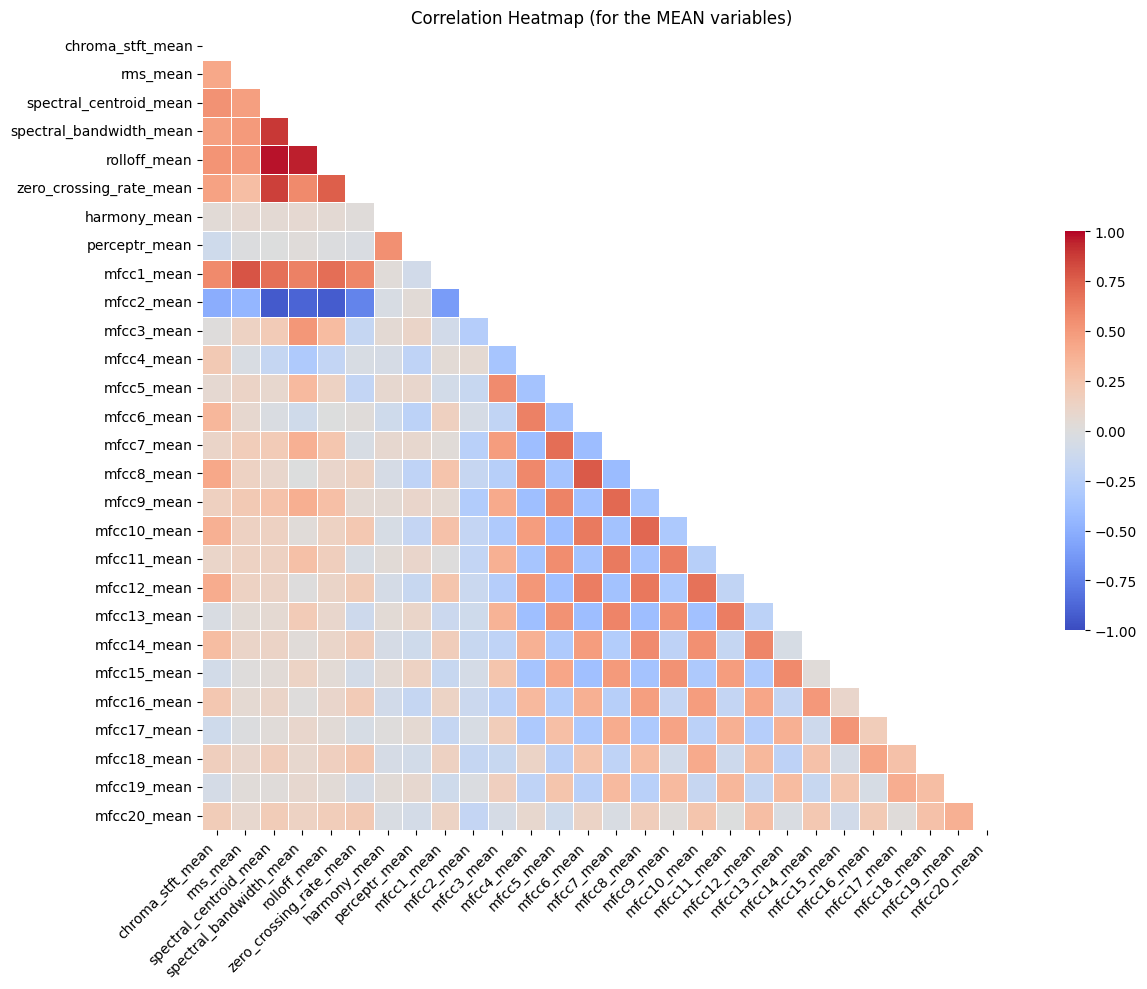

In [73]:

import seaborn as sns


mean_cols = [col for col in df.columns 
             if "mean" in col and col not in ["filename", "label"]]

df_means = df[mean_cols]

corr = df_means.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))   

plt.figure(figsize=(14, 10))
sns.heatmap(
    corr,
    mask=mask,          
    cmap="coolwarm",    
    vmin=-1, vmax=1,   
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": .5}
)
plt.title("Correlation Heatmap (for the MEAN variables)")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()



In [74]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

Train: (7992, 58) Val: (999, 58) Test: (999, 58)


### Model training

In [76]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# define the neighbors
param_grid = {
    "n_neighbors": [3, 5, 7, 9, 11, 15, 21],
    "weights": ["uniform", "distance"],
    "metric": ["minkowski", "manhattan", "cosine"],
    "p": [1, 2]  # only used for minkowski
}

# build the model
knn = KNeighborsClassifier()

# GridSearchCV
grid = GridSearchCV(
    knn,
    param_grid,
    cv=5,                  # 5-fold cross validation
    scoring="accuracy",
    n_jobs=-1,             
    verbose=1
)

grid.fit(X_train_scaled, y_train)

# best parameter
print("Best Parameters:", grid.best_params_)
print("Best CV Accuracy:", grid.best_score_)


Fitting 5 folds for each of 84 candidates, totalling 420 fits
Best Parameters: {'metric': 'minkowski', 'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
Best CV Accuracy: 0.9191697564419565


In [81]:
best_knn = grid.best_estimator_

# testing
test_acc = best_knn.score(X_test_scaled, y_test)
print("Test Accuracy:", test_acc)


Test Accuracy: 0.9259259259259259


In [80]:
from sklearn.metrics import classification_report

y_pred = best_knn.predict(X_test_scaled)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.91      0.91      0.91       100
           1       0.92      0.96      0.94       100
           2       0.89      0.87      0.88        99
           3       0.89      0.93      0.91       100
           4       0.96      0.95      0.95       100
           5       0.90      0.90      0.90       100
           6       0.98      0.98      0.98       100
           7       0.97      0.90      0.93       100
           8       0.91      0.96      0.94       100
           9       0.93      0.90      0.91       100

    accuracy                           0.93       999
   macro avg       0.93      0.93      0.93       999
weighted avg       0.93      0.93      0.93       999



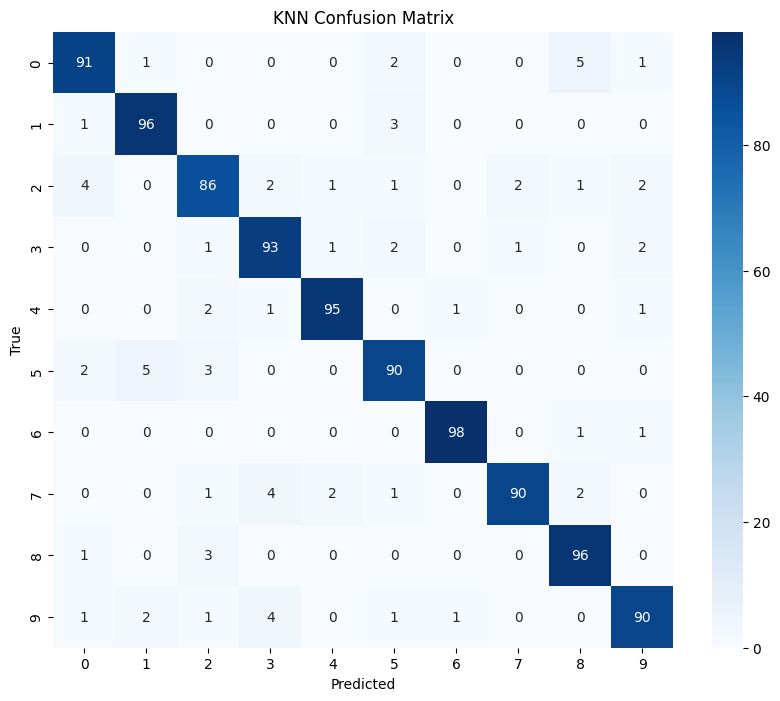

In [84]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("KNN Confusion Matrix")
plt.show()


In [89]:
import tensorflow as tf
from tensorflow import keras as k


input_dim = X_train_scaled.shape[1]


num_classes = y_train.nunique()   

def build_mlp(input_dim, num_classes):
    model = k.models.Sequential([
        k.layers.Input(shape=(input_dim,)),
        k.layers.Dense(256, activation='relu'),
        k.layers.Dropout(0.4),
        k.layers.Dense(128, activation='relu'),
        k.layers.Dropout(0.3),
        k.layers.Dense(64, activation='relu'),
        k.layers.Dense(num_classes, activation='softmax')
    ])
    return model

model_mlp = build_mlp(input_dim, num_classes)
model_mlp.summary()

model_mlp.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  
    metrics=['accuracy']
)

callbacks = [
    k.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=8,
        restore_best_weights=True
    )
]

history_mlp = model_mlp.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=80,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_17 (Dense)                │ (None, 256)            │        15,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 56,906 (222.29 KB)

 Trainable params: 56,906 (222.29 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/80
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.3209 - loss: 1.8846 - val_accuracy: 0.6206 - val_loss: 1.1005
Epoch 2/80
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5768 - loss: 1.1855 - val_accuracy: 0.6877 - val_loss: 0.9065
Epoch 3/80
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6450 - loss: 0.9935 - val_accuracy: 0.7077 - val_loss: 0.8204
Epoch 4/80
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6850 - loss: 0.9067 - val_accuracy: 0.7427 - val_loss: 0.7416
Epoch 5/80
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7161 - loss: 0.8134 - val_accuracy: 0.7528 - val_loss: 0.6876
Epoch 6/80
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7317 - loss: 0.7658 - val_accuracy: 0.7688 - val_loss: 0.6536
Epoch 7/80
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7451 - loss: 0.7258 - val_accuracy: 0.7858 - val_loss: 0.6160
Epoch 8/80
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7590 - loss: 0.6987 - val_accuracy: 0.

MLP Test Accuracy: 0.9029029011726379
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

MLP Classification Report (Test):
               precision    recall  f1-score   support

           0       0.96      0.91      0.93       100
           1       0.94      0.95      0.95       100
           2       0.85      0.89      0.87        99
           3       0.88      0.81      0.84       100
           4       0.94      0.87      0.90       100
           5       0.88      0.95      0.91       100
           6       0.95      0.97      0.96       100
           7       0.90      0.91      0.91       100
           8       0.85      0.94      0.90       100
           9       0.88      0.83      0.86       100

    accuracy                           0.90       999
   macro avg       0.90      0.90      0.90       999
weighted avg       0.90      0.90      0.90       999



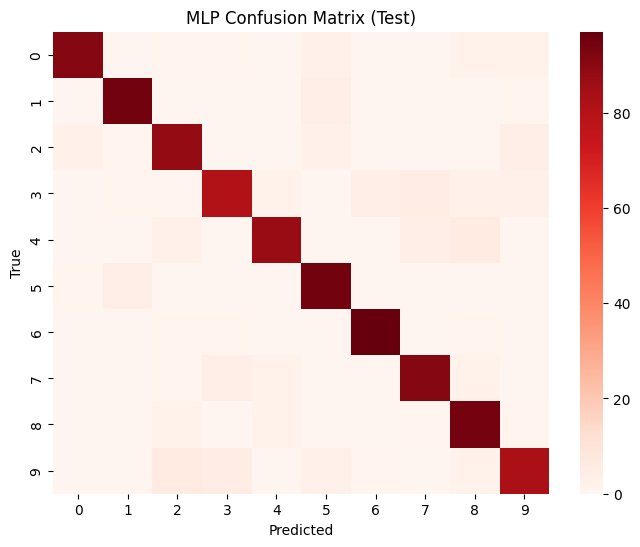

In [90]:
test_loss, test_acc = model_mlp.evaluate(X_test_scaled, y_test, verbose=0)
print("MLP Test Accuracy:", test_acc)

y_test_pred_mlp = model_mlp.predict(X_test_scaled).argmax(axis=1)
print("\nMLP Classification Report (Test):\n",
      classification_report(y_test, y_test_pred_mlp))

cm_mlp = confusion_matrix(y_test, y_test_pred_mlp)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_mlp, cmap="Reds", annot=False)
plt.title("MLP Confusion Matrix (Test)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [ ]:
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Data Preparation ---

# Separate features (X) and target (y)
# We drop 'filename' because it's just an ID, and 'label' because it's the answer.
X = df.drop(columns=['filename', 'label'])
y = df['label']

# Encode the text labels (e.g., "Rock" -> 0, "Jazz" -> 1)
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split into Train and Test sets
# Stratify ensures we get an equal mix of genres in both sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Scale the features
# (XGBoost handles unscaled data well, but scaling helps with convergence and comparing to MLP)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- 2. Build and Train XGBoost ---
print("Training XGBoost Model...")
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    eval_metric='mlogloss',
    random_state=42
)

# Use the SCALED data you created in Cell 29/30
xgb_model.fit(X_train_scaled, y_train) 

# --- 3. Evaluation ---
y_pred_xgb = xgb_model.predict(X_test_scaled) # Use a distinct variable name

# Convert numbers back to names for the report (0 -> "Rock")
y_pred_names = le.inverse_transform(y_pred)
y_test_names = le.inverse_transform(y_test)

# Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"\nXGBoost Test Accuracy: {acc:.4f}")

# Detailed Report
print("\nClassification Report:")
print(classification_report(y_test_names, y_pred_names))

# Confusion Matrix
plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_test_names, y_pred_names, labels=le.classes_)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('XGBoost Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()